Before finalizing RNA-seq criteria, I need to make sure that all required fields are there and that they are correct.

In [3]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)

last updated: 2017-08-11 
Git hash: f49c7cd138c49745eb47c26deb179f78c6a5da79


In [4]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
ncbi = db['ncbi']
remap = db['remap']

In [5]:
# Other imports


In [6]:
# Grab NCBI annotation and make data frame. Will be useful for coloring.
anno = pd.DataFrame(list(ncbi.aggregate([
    {'$unwind': '$sra.experiment'},
    {
        '$match': {
            'sra.run.run_id': {"$exists": 1}
        }
    },
    {'$unwind': '$sra.run'},
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$sra.run.run_id',
            'flag_annotated_rnaseq': {
                '$cond': [
                    {
                        # A run is annotated as rnaseq if one of these is true
                        '$and': [
                            {'$eq': ['RNA-Seq', '$sra.experiment.library_strategy']},
                            {'$eq': ['PolyA', '$sra.experiment.library_selection']},
                        ]
                    }, 
                    True, 
                    False
                ], 
            }
        }
    }
])))
anno.set_index(['srx', 'srr'], inplace=True)

# List of pre-aln-flags
[x['_id'] for x in remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$project': {
            '_id': 0,
            'flags': '$runs.pre_aln_flags'
        }
    },
    {'$unwind': '$flags'},
    {'$group': {'_id': '$flags'}}
])]

['quality_scores_bad',
 'download_bad',
 'SE',
 'keep_R2',
 'first_strand',
 'complete',
 'unstranded',
 'second_strand',
 'PE',
 'same_strand',
 'opposite_strand',
 'alignment_bad',
 'keep_R1',
 'abi_solid']

In [109]:
remap.find_one({
    'runs.pre_aln_workflow.featurecounts': {'$exists': 1},
    'runs.pre_aln_flags': 'SE'
})

{'_id': 'SRX2556775',
 'bioproject': 'PRJNA374562',
 'contacts': [{'email': 'alrouth@utmb.edu',
   'first_name': 'Andrew',
   'last_name': 'Routh'}],
 'papers': [],
 'runs': [{'avgReadLen': {'R1': 151.0, 'R2': 0.0},
   'libsize': {'R1': 2182591, 'R2': 2182591},
   'md5': {'R1': '0d172b3db231285bf6c5ac22886655d6',
    'R2': '3217971c2b74f78d0043a7df05f5d93b'},
   'pre_aln_flags': ['SE', 'keep_R1', 'same_strand', 'complete'],
   'pre_aln_workflow': {'bam_stat': {'non_unique': 36434,
     'nonsplice_reads': 641119,
     'optical_pcr_duplicates': 0,
     'proper_pair_map_to_different_chrom': 0,
     'qc_failed': 0,
     'read_1': 0,
     'read_2': 0,
     'reads_map_minus': 392273,
     'reads_map_plus': 335789,
     'reads_mapped_proper_pairs': 0,
     'splice_reads': 86943,
     'total_records': 2255067,
     'unique': 728062,
     'unmapped_reads': 1418095},
    'fastq_screen': {'adapters': {'multiple_hits_multiple_libraries_count': 5163.0,
      'multiple_hits_multiple_libraries_percen

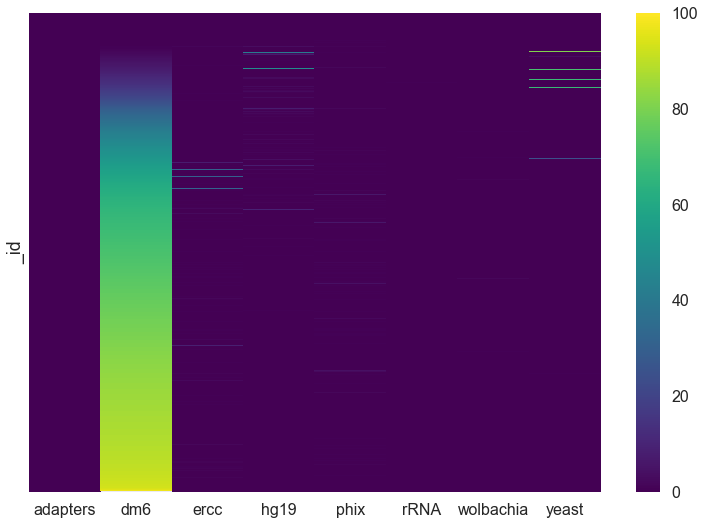

In [8]:
# Look at fastq screen results
fqs = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow.fastq_screen': {'$exists': 1},
        }
    },
    {
        '$project': {
            'adapters': '$runs.pre_aln_workflow.fastq_screen.adapters.one_hit_one_library_percent',
            'dm6': '$runs.pre_aln_workflow.fastq_screen.dm6.one_hit_one_library_percent',
            'ecoli': '$runs.pre_aln_workflow.fastq_screen.ecoli._hit_one_library_percent',
            'ercc': '$runs.pre_aln_workflow.fastq_screen.ercc.one_hit_one_library_percent',
            'hg19': '$runs.pre_aln_workflow.fastq_screen.hg19.one_hit_one_library_percent',
            'phix': '$runs.pre_aln_workflow.fastq_screen.phix.one_hit_one_library_percent',
            'rRNA': '$runs.pre_aln_workflow.fastq_screen.rRNA.one_hit_one_library_percent',
            'wolbachia': '$runs.pre_aln_workflow.fastq_screen.wolbachia.one_hit_one_library_percent',
            'yeast': '$runs.pre_aln_workflow.fastq_screen.yeast.one_hit_one_library_percent',
        }
    },
]))

fqscreen = pd.DataFrame(fqs)
fqscreen.set_index('_id', inplace=True)
fqscreen.sort_values('dm6', inplace=True)
#bob.sort_index(inplace=True)
sns.heatmap(fqscreen, yticklabels=False, cmap='viridis')

≥75%: 8,663
≥95%: 6,177
≥99%: 2,923


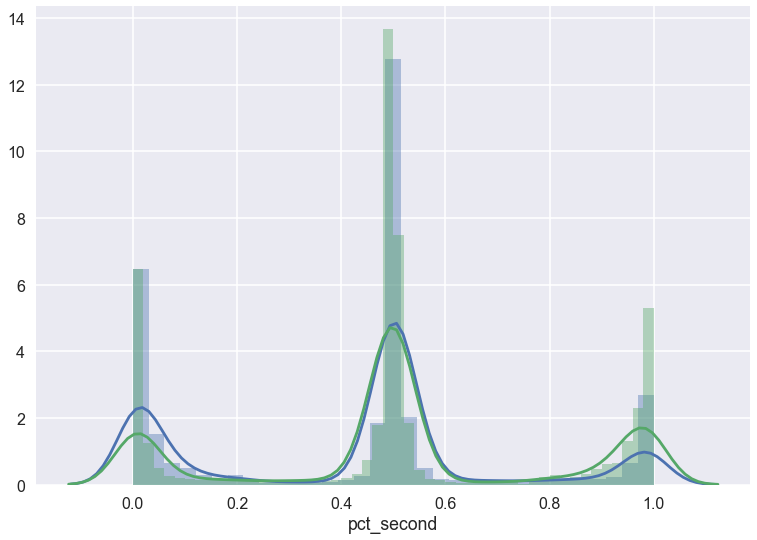

In [103]:
# Look at strandedness using picard
strand = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow.picard_collectrnaseqmetrics.first': {'$exists': 1},
        }
    },
    {
        '$project': {
            'pct_first': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.first.PCT_CORRECT_STRAND_READS',
            'pct_second': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.second.PCT_CORRECT_STRAND_READS'
        }
    },
]))

stranded = pd.DataFrame(strand)
stranded.set_index('_id', inplace=True)
stranded.dropna(inplace=True)

sns.distplot(stranded.pct_first)
sns.distplot(stranded.pct_second)

gt75 = stranded[(stranded.pct_first > 0.75) | (stranded.pct_second > 0.75)].dropna()
gt95 = stranded[(stranded.pct_first > 0.95) | (stranded.pct_second > 0.95)].dropna()
gt99 = stranded[(stranded.pct_first >= 0.99) | (stranded.pct_second >= 0.99)].dropna()

print(
    '≥75%: {:,}\n'
    '≥95%: {:,}\n'
    '≥99%: {:,}'.format(gt75.shape[0], gt95.shape[0], gt99.shape[0])
)

In [78]:
# check that md5s are unique
agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.srr': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'md5R1': '$runs.md5.R1',
            'md5R2': '$runs.md5.R2',
            }
    },
]))

_df = pd.DataFrame(agg)

# stack dataset to have only 1 column of md5sums
_df.set_index(['srx', 'srr'], inplace=True)
_stacked = _df.stack().to_frame()

# Add column of ones for easy counting
_stacked['cnt'] = 1
counter = _stacked.groupby(0).sum()

# Are there any md5s with more than one
cnt = sum(counter.cnt > 1)
print('There are {:,} md5s in the database more than once.'.format(cnt))

There are 0 md5s in the database more than once.


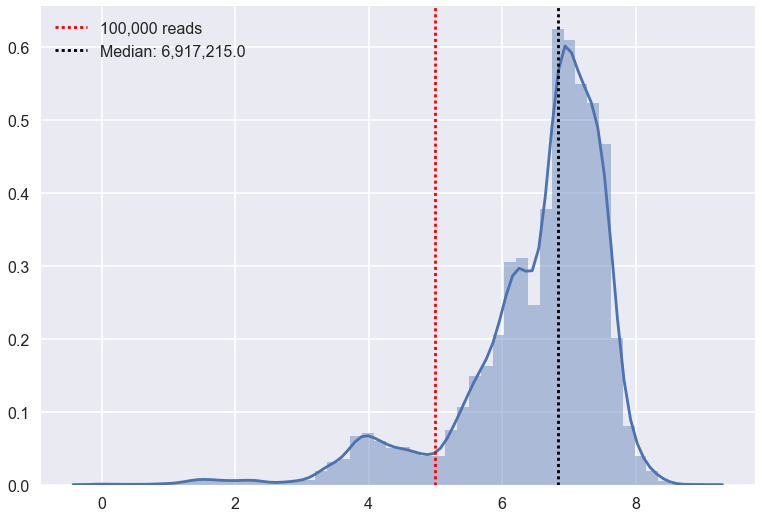

In [101]:
# distribution of read counts

agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'cnts': '$runs.libsize.R1',
        }
    }
]))

_df = pd.DataFrame(agg)
_df.set_index(['srx', 'srr'], inplace=True)

_clean = _df.dropna()
_median = _clean.cnts.median()
ax = sns.distplot(np.log10(_clean))
ax.axvline(np.log10(1e5), color='r', ls=':', label='100,000 reads')
ax.axvline(np.log10(_median), color='k', ls=':', label='Median: {:,}'.format(_median))
ax.legend();

≥50: 13,984 samples
≥75: 4,856 samples
≥80: 2,994 samples
≥90: 243 samples


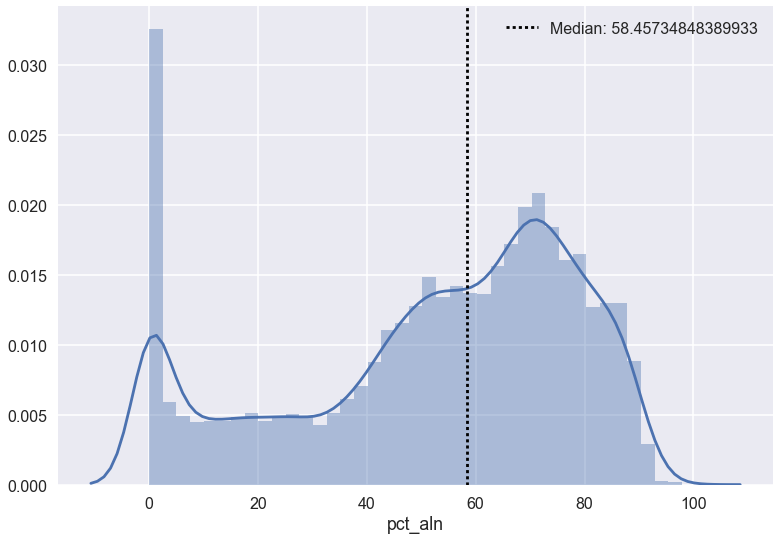

In [137]:
# Percent Alignment 
alns_pe = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow.hisat2.num_reads': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'num_reads': '$runs.pre_aln_workflow.hisat2.num_reads',
            'num_unaligned': '$runs.pre_aln_workflow.hisat2.num_unaligned',
            'num_unique_aln': {
                '$cond': [
                    {'$in': ['PE', '$runs.pre_aln_flags']},
                    '$runs.pre_aln_workflow.hisat2.num_concordant_reads_uniquely_aligned',
                    '$runs.pre_aln_workflow.hisat2.num_uniquely_algined',
                ]
            }
            
        }
    }
]))
_df = pd.DataFrame(alns_pe)
_df.set_index(['srx', 'srr'], inplace=True)
_df['pct_aln'] = _df.num_unique_aln / _df.num_reads * 100
_cleaned = _df.pct_aln.dropna()

gt50 = (_cleaned >= 50).sum()
gt75 = (_cleaned >= 75).sum()
gt80 = (_cleaned >= 80).sum()
gt90 = (_cleaned >= 90).sum()

print(
'≥50: {:,} samples\n'
'≥75: {:,} samples\n'
'≥80: {:,} samples\n'
'≥90: {:,} samples'.format(gt50, gt75, gt80, gt90)
)
ax = sns.distplot(_cleaned);
ax.axvline(_cleaned.median(), color='k', ls=':', label='Median: {:,}'.format(_cleaned.median()))
ax.legend();

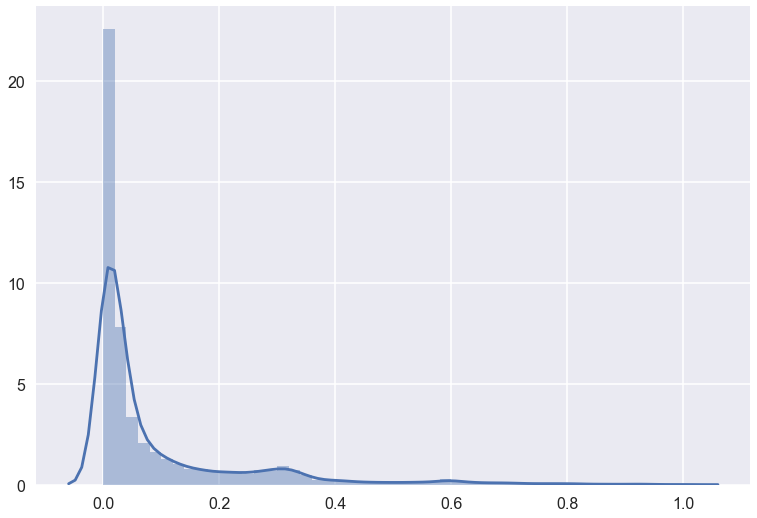

In [165]:
# PCT Intergenic
agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'pct_intergenic': {
                '$cond': {
                    'if': {'$in': ['same_strand', '$runs.pre_aln_flags']},
                    'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.first.PCT_INTERGENIC_BASES',
                    'else': {
                        '$cond': {
                            'if': {'$in': ['opposite_strand', '$runs.pre_aln_flags']},
                            'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.second.PCT_INTERGENIC_BASES',
                            'else': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.unstranded.PCT_INTERGENIC_BASES',
                            
                        }
                    }
                }
            }
        }
    }
]))
_df = pd.DataFrame(agg)
_df.set_index(['srx', 'srr'], inplace=True)
_cleaned = _df.dropna()

sns.distplot(_cleaned)

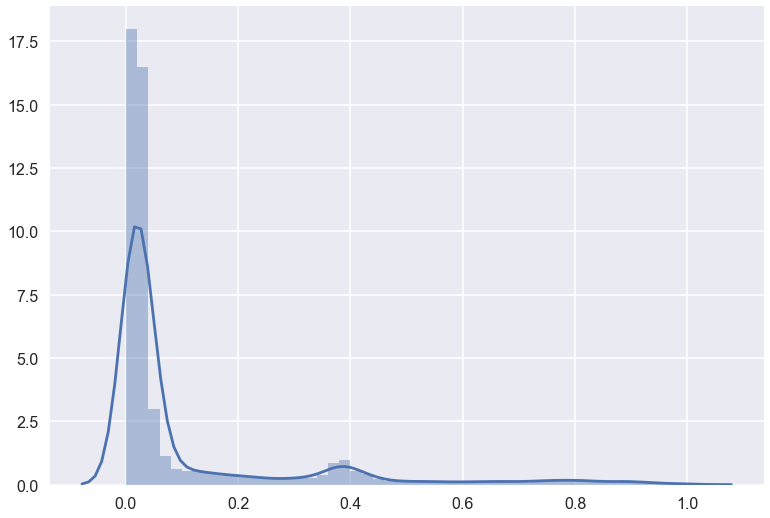

In [164]:
# PCT Intronic
agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'pct_intergenic': {
                '$cond': {
                    'if': {'$in': ['same_strand', '$runs.pre_aln_flags']},
                    'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.first.PCT_INTRONIC_BASES',
                    'else': {
                        '$cond': {
                            'if': {'$in': ['opposite_strand', '$runs.pre_aln_flags']},
                            'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.second.PCT_INTRONIC_BASES',
                            'else': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.unstranded.PCT_INTRONIC_BASES',
                            
                        }
                    }
                }
            }
        }
    }
]))
_df = pd.DataFrame(agg)
_df.set_index(['srx', 'srr'], inplace=True)
_cleaned = _df.dropna()

sns.distplot(_cleaned)

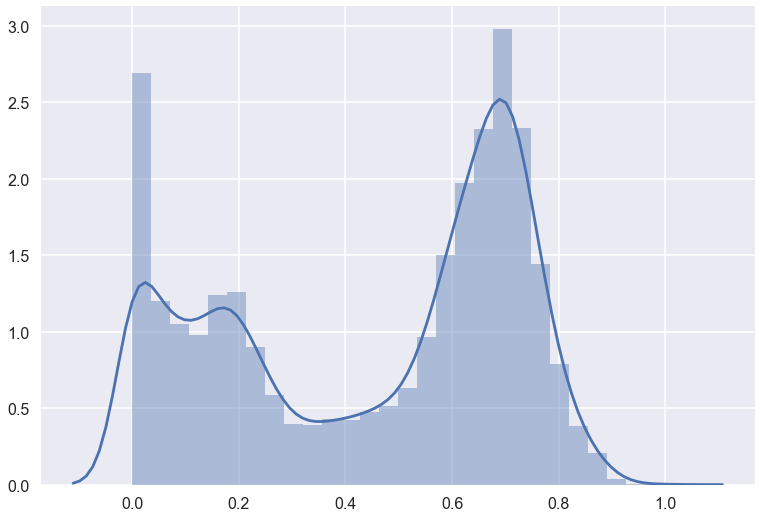

In [166]:
# PCT Coding
agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'pct_intergenic': {
                '$cond': {
                    'if': {'$in': ['same_strand', '$runs.pre_aln_flags']},
                    'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.first.PCT_CODING_BASES',
                    'else': {
                        '$cond': {
                            'if': {'$in': ['opposite_strand', '$runs.pre_aln_flags']},
                            'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.second.PCT_CODING_BASES',
                            'else': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.unstranded.PCT_CODING_BASES',
                            
                        }
                    }
                }
            }
        }
    }
]))
_df = pd.DataFrame(agg)
_df.set_index(['srx', 'srr'], inplace=True)
_cleaned = _df.dropna()

sns.distplot(_cleaned)

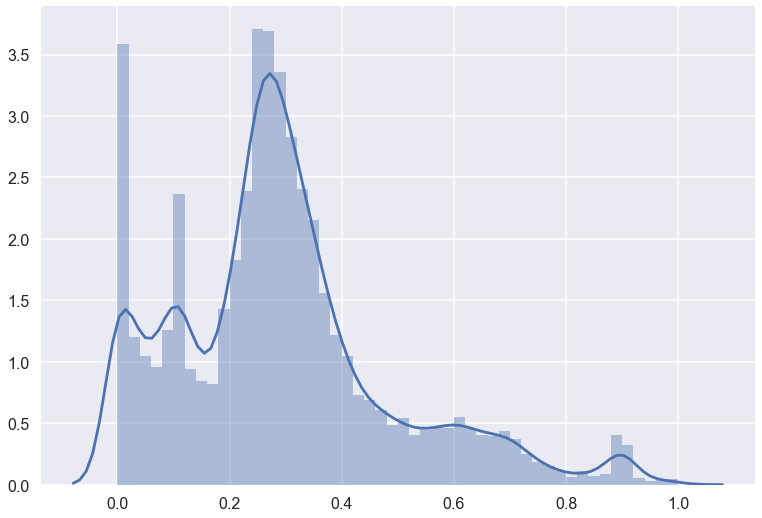

In [167]:
# PCT UTR
agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'pct_intergenic': {
                '$cond': {
                    'if': {'$in': ['same_strand', '$runs.pre_aln_flags']},
                    'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.first.PCT_UTR_BASES',
                    'else': {
                        '$cond': {
                            'if': {'$in': ['opposite_strand', '$runs.pre_aln_flags']},
                            'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.second.PCT_UTR_BASES',
                            'else': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.unstranded.PCT_UTR_BASES',
                            
                        }
                    }
                }
            }
        }
    }
]))
_df = pd.DataFrame(agg)
_df.set_index(['srx', 'srr'], inplace=True)
_cleaned = _df.dropna()

sns.distplot(_cleaned)

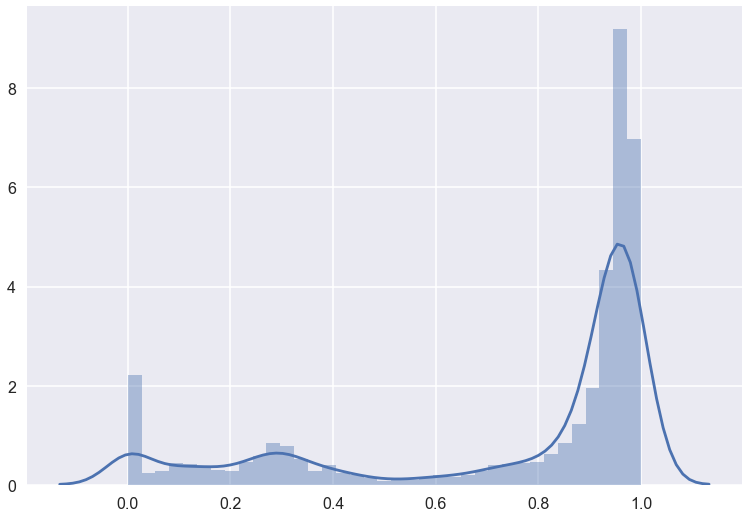

In [168]:
# PCT MRNA
agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'pct_intergenic': {
                '$cond': {
                    'if': {'$in': ['same_strand', '$runs.pre_aln_flags']},
                    'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.first.PCT_MRNA_BASES',
                    'else': {
                        '$cond': {
                            'if': {'$in': ['opposite_strand', '$runs.pre_aln_flags']},
                            'then': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.second.PCT_MRNA_BASES',
                            'else': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics.unstranded.PCT_MRNA_BASES',
                            
                        }
                    }
                }
            }
        }
    }
]))
_df = pd.DataFrame(agg)
_df.set_index(['srx', 'srr'], inplace=True)
_cleaned = _df.dropna()

sns.distplot(_cleaned)

≤25: 4,797
≤50: 7,789
≤75: 14,598


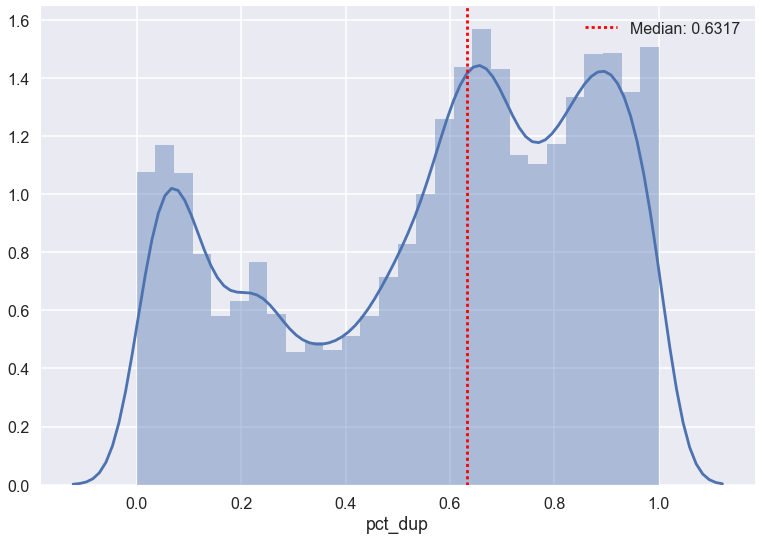

In [230]:
# Duplication Rate

agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow.picard_markduplicates.PERCENT_DUPLICATION': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'srr': '$runs.srr',
            'pct_dup': '$runs.pre_aln_workflow.picard_markduplicates.PERCENT_DUPLICATION',
        }
    }
]))
_df = pd.DataFrame(agg)
_df.set_index(['srx', 'srr'], inplace=True)

_cleaned = _df.pct_dup.dropna()
_cleaned = _cleaned[_cleaned != '?']

lt25 = (_cleaned <= .25).sum()
lt50 = (_cleaned <= .50).sum()
lt75 = (_cleaned <= .75).sum()
print(
'≤25: {:,}\n'
'≤50: {:,}\n'
'≤75: {:,}'.format(lt25, lt50, lt75)
)

median = _cleaned.median()
ax = sns.distplot(_cleaned)
ax.axvline(median, color='r', ls=':', label='Median: {:,}'.format(np.round(median, 4)))
ax.legend()

In [255]:
remap.find_one({'runs.srr': 'SRR5278103'})

{'_id': 'SRX2581987',
 'bioproject': 'PRJNA357269',
 'contacts': [{'email': 'marcelorivas@gmail.com',
   'first_name': 'Marcelo',
   'last_name': 'Rivas'}],
 'papers': [],
 'runs': [{'avgReadLen': {'R1': 142.97425121403273, 'R2': 143.68871950516282},
   'libsize': {'R1': 17428278, 'R2': 17428278},
   'md5': {'R1': '1ef1ee5447afb2a8852f52224abf3940',
    'R2': '144600f42c19d3c2101b968d9f834567'},
   'pre_aln_flags': ['PE', 'unstranded', 'complete'],
   'pre_aln_workflow': {'bam_stat': {'non_unique': 292001,
     'nonsplice_reads': 3841210,
     'optical_pcr_duplicates': 0,
     'proper_pair_map_to_different_chrom': 0,
     'qc_failed': 0,
     'read_1': 2098571,
     'read_2': 1773091,
     'reads_map_minus': 1935259,
     'reads_map_plus': 1936403,
     'reads_mapped_proper_pairs': 3238278,
     'splice_reads': 30452,
     'total_records': 35575122,
     'unique': 3871662,
     'unmapped_reads': 30692893},
    'fastq_screen': {'adapters': {'multiple_hits_multiple_libraries_count': 86.0